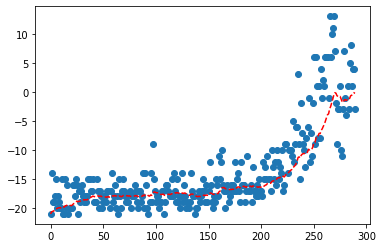

In [1]:
import pygame  
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

import torch
from torch import nn
from torch.nn.utils import clip_grad_norm_

class pong():
    def __init__(self) -> None:
        pygame.init()  
        self.step_size = 4
        self.screen_width, self.screen_height = 400,400
        self.screen = pygame.display.set_mode((self.screen_width, self.screen_height))  
        self.ball = self.ball(screen_width = self.screen_width, screen_height = self.screen_height, step_size = self.step_size)
        self.player_one = self.pad(x = 10, screen_width = self.screen_width, screen_height = self.screen_height, step_size = self.step_size)
        self.player_two = self.pad(x = self.screen_width - 20, screen_width = self.screen_width, screen_height = self.screen_height, step_size = self.step_size)
        self.reset()

    def reset(self):
        self.ball.reset()
        self.player_one.reset()
        self.player_two.reset()
        self.player_one_score = 0
        self.player_two_score = 0
        return self.get_state()

    def get_state(self):
        dx,dy = self.ball.dx/self.step_size, self.ball.dy/self.step_size
        state_a = abs(self.ball.x - self.player_one.x) / self.screen_width , (self.ball.y - (self.player_one.y + (self.player_one.height / 2))) / self.screen_height, -dx, dy
        state_b = abs(self.ball.x - self.player_two.x) / self.screen_width , (self.ball.y - (self.player_two.y + (self.player_two.height / 2))) / self.screen_height, dx, dy
        return np.array([state_a, state_b])

    def step(self, action):
        action[0] = 1 if self.ball.y < self.player_one.y + (self.player_one.height / 2) else 0
        self.player_one.step(action[0])
        self.player_two.step(action[1])
        reward = self.ball.step()
        self.player_one_score += 1 if reward[0] == 1 else 0
        self.player_two_score += 1 if reward[1] == 1 else 0
        for i, pad in enumerate([self.player_one, self.player_two]):
            if (abs(pad.x - self.ball.x) <= self.step_size) and (abs(pad.y + (pad.height / 2) - self.ball.y) <= (pad.height / 2)):
                self.ball.dx = -self.ball.dx    
                self.ball.x += 2*self.ball.dx    
                self.ball.dy += np.random.rand() if np.random.rand() < 0.5 else -np.random.rand()

        return self.get_state(), action, reward, max(self.player_one_score, self.player_two_score) == 21

    def render(self):
        self.screen.fill((0,0,0))
        self.ball.draw(self.screen)
        self.player_one.draw(self.screen)
        self.player_two.draw(self.screen)
        pygame.display.update()

    class pad():
        def __init__(self, x, screen_width, screen_height, step_size) -> None:
            self.x = x
            self.width = 10
            self.height = 40
            self.step_size = step_size
            self.screen_width = screen_width
            self.screen_height = screen_height
            self.reset()

        def reset(self):
            self.y = self.screen_height//2

        def step(self, action):
            step_is_valid = not ((self.y <= 0 and action)  or (self.y + self.height > self.screen_height and not action))
            if step_is_valid:
                self.y += -self.step_size if action else self.step_size 

        def draw(self, screen):
            pygame.draw.rect(screen, (255, 255, 255), pygame.Rect(self.x, self.y, self.width, self.height))  

    class ball():
        def __init__(self, screen_width, screen_height, step_size) -> None:
            self.radius = 5
            self.step_size = step_size
            self.screen_width = screen_width
            self.screen_height = screen_height
            self.reset()
            
        def reset(self):
            self.x = self.screen_width//2
            self.y = np.random.rand()*self.screen_height
            self.dx = self.step_size if np.random.rand() < 0.5 else -self.step_size 
            self.dy = self.step_size if np.random.rand() < 0.5 else -self.step_size 

        def step(self):
            self.x += self.dx
            self.y += self.dy
            reward = 0, 0
            if self.x < 0 or self.x > self.screen_width:
                reward = (-1,1) if self.x < 0 else (1,-1)
                self.reset()
            elif self.y <= 0 or self.y > self.screen_height-self.radius:
                self.dy = -self.dy
            return reward
        
        def draw(self, screen):
            pygame.draw.circle(screen, (255, 255, 255),(self.x,self.y), self.radius)

class ReplayBuffer(object):
    def __init__(self, capacity, state_dim):
        self.idx = 0
        self.is_full = False
        self.capacity = capacity
        self.state_running_mean = None
        self.state_running_std = None
        self.memory = {'state':np.zeros((capacity, state_dim), dtype=np.float32),
                        'action':np.zeros((capacity), dtype=int),
                        'reward':np.zeros((capacity), dtype=np.float32),
                        'next_state':np.zeros((capacity, state_dim), dtype=np.float32),
                        'done':np.zeros((capacity), dtype=bool)}

    def push_episode(self, batch):
        for ind, k in enumerate(self.memory.keys()):
            i,j = self.idx, min(self.idx+len(batch[0]), self.capacity)
            self.memory[k][i:j] = batch[ind][:j-i]
        self.idx += len(batch[0])
        if self.idx >= self.capacity:
            self.idx, self.is_full = 0, True

    def sample_batch(self, batch_size = 256):
        sample_idx = np.random.choice(self.__len__(), batch_size, replace=True) 
        return [self.memory[k][sample_idx] for k in self.memory.keys()]           

    def __len__(self):
        return self.capacity if self.is_full else self.idx

class MLP(nn.Module):
    def __init__(self, state_dim, h_dim, action_dim):
        super().__init__()
        self.layers = nn.Sequential( nn.Linear(state_dim, h_dim), nn.ReLU(),\
                                     nn.Linear(h_dim, h_dim*2), nn.ReLU(),\
                                     nn.Linear(h_dim*2, action_dim))
    def forward(self, x):
        return self.layers(x)

class dqn_agent():
    def __init__(self, state_dim, h_dim, action_dim) -> None:
        self.step = 0
        self.gamma = 0.99
        self.update_step_interval = 4
        self.init_random_steps = 10000
        self.update_target_network = 10000
        self.epsilon, self.epsilon_min, epsilon_greedy_steps = 1.0, 0.0, 1e+6
        self.epsilon_decay_step = (self.epsilon - self.epsilon_min) / epsilon_greedy_steps

        self.num_actions = action_dim
        self.model = MLP(state_dim, h_dim, action_dim)
        self.target_model = MLP(state_dim, h_dim, action_dim)
        self.loss_fn = torch.nn.HuberLoss()
        self.optimizer = torch.optim.RMSprop(self.model.parameters(), lr=0.00025)
        self.replay_buffer = ReplayBuffer(capacity=int(1e+7), state_dim=state_dim)
        self.reset_memory()

    def reset_memory(self):
        self.states, self.actions, self.rewards, self.next_states, self.dones = [], [], [], [], []

    def TD(self, arr, lambda_):
        for i in range(len(arr)):
            arr[i] = arr[min(i+lambda_, len(arr)-1)]
        return arr

    def push_step(self, s, a, r, ns, done):
        self.states.extend(s), self.actions.extend(a), self.rewards.extend(r), self.next_states.extend(ns), self.dones.extend(done)
        if done:

            self.replay_buffer.push_episode([self.states[::2], self.actions[::2], \
                self.discounted_rewards(self.rewards[::2]), self.TD(self.next_states[::2], 5), self.dones[::2]])

            self.replay_buffer.push_episode([self.states[1::2], self.actions[1::2], \
                self.discounted_rewards(self.rewards[1::2]), self.TD(self.next_states[1::2], 5), self.dones[1::2]])

            self.reset_memory()

    def select_action(self, state):
        self.step+=1
        self.epsilon = max(self.epsilon-self.epsilon_decay_step, self.epsilon_min)
        if self.epsilon > np.random.rand():
            return [np.random.choice(self.num_actions), np.random.choice(self.num_actions)]

        return self.model(torch.FloatTensor(state)).argmax(dim=1).numpy()

    def discounted_rewards(self, rewards, discount_rate = 0.98):
        for i in reversed(range(len(rewards)-1)):
            if rewards[i] == 0:  
                rewards[i] += discount_rate * rewards[i+1]
        return rewards
    
    def ddqn_loss(self, batch):
        states, actions, rewards, next_states, dones = batch
        with torch.no_grad():
            future_action = self.model(next_states).argmax(dim=1).unsqueeze(1)
            future_rewards = self.target_model(next_states).detach().gather(1, future_action).squeeze()
        target_q_values = rewards + self.gamma * (future_rewards * (1 - dones))
        q_values = self.model(states).gather(1, actions.unsqueeze(1)).squeeze()
        return self.loss_fn(q_values, target_q_values)
    
    def training_step(self):
        if self.step % self.update_step_interval == 0 and self.step > self.init_random_steps:
            states, actions, rewards, next_state, done = self.replay_buffer.sample_batch()
            states, actions, rewards, next_state, done = torch.FloatTensor(states), torch.LongTensor(actions), \
                                                            torch.FloatTensor(rewards), torch.FloatTensor(next_state), torch.IntTensor(done)
            self.optimizer.zero_grad()
            loss = self.ddqn_loss([states, actions, rewards, next_state, done])
            loss.backward()
            clip_grad_norm_(self.model.parameters(), max_norm=2)
            self.optimizer.step()

        if self.step % self.update_target_network == 0:
            self.target_model.load_state_dict(self.model.state_dict())

def plot_durations(score, score_running_avgs):
    clear_output()
    plt.plot(np.arange(len(score)), score_running_avgs, 'r--')
    plt.scatter(np.arange(len(score)), score)
    plt.show()

env = pong()
reward_sum = 0
state = env.reset()
next_state = np.zeros(state.shape)
score, score_running_avgs = [-21], [-21]
agent = dqn_agent(state_dim = len(state[0]), h_dim = 32, action_dim = 2)
while score_running_avgs[-1] <= 0:
    #env.render()
    action = agent.select_action(state)
    next_state, action, reward, done = env.step(action)
    if reward == 0:
        next_state, action, reward, done = env.step(action)
    reward_sum += reward[1]
    agent.push_step(state, action, reward, next_state, [done,done])
    agent.training_step()
    state = next_state
    if done:
        score.append(reward_sum)
        score_running_avgs.append( 0.95 * score_running_avgs[-1] + 0.05 * score[-1])
        state = env.reset()
        reward_sum=0
        if len(score) % 10 == 0:
            plot_durations(score, score_running_avgs)
